In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Data Processing").getOrCreate()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=dae66c65fff92c29a4d2f33e0e424f85e32116a4bee1184a18b219989367e1c9
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
df = spark.read.csv('/content/loandata.csv', header=True, inferSchema=True)

In [ ]:
# Define income ranges and corresponding folder names
income_partitions = {
    "1000_9999": (999, 10000),
    "10001_49999": (10001, 49999),
    "50000_100000": (50000, 100000),
    "above_100000": (100000, float('inf'))
}

# Base path for saving partitioned data
base_path = "/content/partitioned_data/"

for key, (lower_bound, upper_bound) in income_partitions.items():
    partition_df = df.filter((df.customer_income > lower_bound) & (df.customer_income <= upper_bound))
    partition_path = f"{base_path}{key}"
    partition_df.write.format("parquet").mode("overwrite").save(partition_path)


In [ ]:
import os
import glob

# Base path for partitioned data
base_path = "/content/partitioned_data/"

# Function to calculate the total size of files in a directory
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.exists(fp):
                total_size += os.path.getsize(fp)
    return total_size

# Calculate and print the size of each partition
for partition_name in os.listdir(base_path):
    partition_path = os.path.join(base_path, partition_name)
    if os.path.isdir(partition_path):
        size_in_mb = get_size(partition_path) / (1024 * 1024)  # convert bytes to megabytes
        print(f"Size of partition {partition_name}: {size_in_mb:.2f} MB")


Size of partition 10001_49999: 0.16 MB
Size of partition 1000_9999: 0.01 MB
Size of partition above_100000: 0.06 MB
Size of partition 50000_100000: 0.17 MB


Time taken to read files without caching: 7.128715515136719e-05 seconds
Time taken to read files with caching: 4.553794860839844e-05 seconds


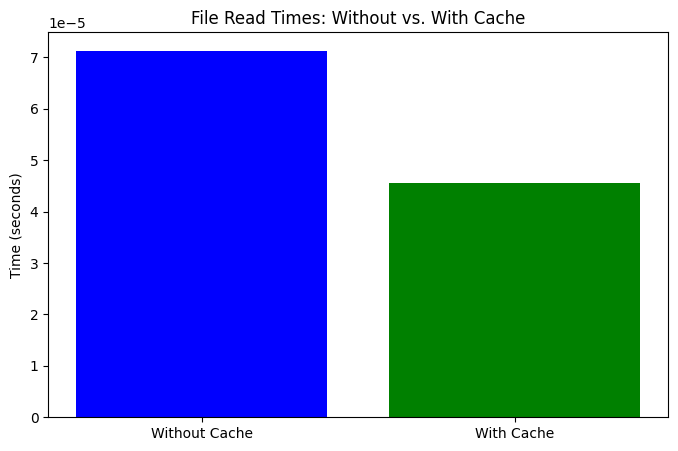

In [ ]:
import time
import pandas as pd
import os
import matplotlib.pyplot as plt

def read_parquet_files_with_caching(directory, use_cache=True):
    start_time = time.time()
    file_contents = []
    # Read each Parquet file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.parquet'):
            filepath = os.path.join(directory, filename)
            if use_cache:
                df = pd.read_parquet(filepath, engine='pyarrow', use_threads=True)
            else:
                df = pd.read_parquet(filepath, engine='pyarrow', use_threads=False)
            file_contents.append(df)
    end_time = time.time()
    return end_time - start_time, len(file_contents)

directory = '/content/partitioned_data'  # Directory containing your Parquet files

# Measure read time without caching
time_without_cache, _ = read_parquet_files_with_caching(directory, use_cache=False)
print(f"Time taken to read files without caching: {time_without_cache} seconds")

# Measure read time with caching
time_with_cache, _ = read_parquet_files_with_caching(directory, use_cache=True)
print(f"Time taken to read files with caching: {time_with_cache} seconds")

# Plotting the results
times = [time_without_cache, time_with_cache]
labels = ['Without Cache', 'With Cache']

plt.figure(figsize=(8, 5))
plt.bar(labels, times, color=['blue', 'green'])
plt.ylabel('Time (seconds)')
plt.title('File Read Times: Without vs. With Cache')
plt.show()


Filtering at Read took 0.49 seconds
Repartitioning Data took 0.37 seconds
Using Broadcast took 2.16 seconds


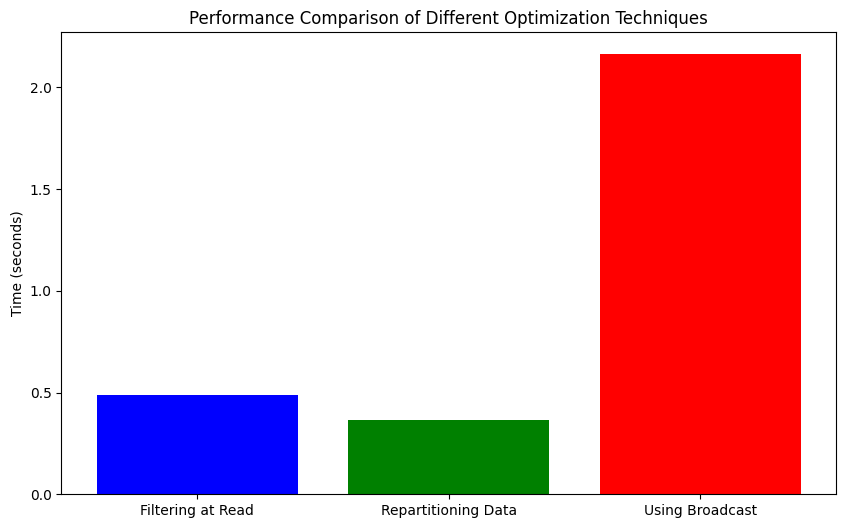

In [ ]:
from pyspark.sql import SparkSession
import time
import matplotlib.pyplot as plt

# Initialize a Spark session
spark = SparkSession.builder.appName("Optimization Techniques").getOrCreate()

# Function to measure the execution time
def measure_time(method, function):
    start_time = time.time()
    result = function()
    end_time = time.time()
    print(f"{method} took {end_time - start_time:.2f} seconds")
    return end_time - start_time

# Read Parquet files
df = spark.read.parquet('/content/partitioned_data/10001_49999')

# Method 1: Data Filtering at Read Time
def filtering_at_read():
    # Ensure 'loan_intent' and 'Education' match your data
    return spark.read.parquet('/content/partitioned_data/10001_49999').filter("loan_intent = 'Education'").count()

# Method 2: Repartitioning Data
def repartition_data():
    repartitioned_df = df.repartition(10)  # Adjust the number of partitions
    return repartitioned_df.count()

# Method 3: Broadcast Variables
def using_broadcast():
    # This example assumes that 'Education' is a common value in 'loan_intent'
    broadcast_var = spark.sparkContext.broadcast({'loan_intent': 'Education'})
    small_df = spark.createDataFrame([("Education",)], ["loan_intent"])
    return df.join(small_df, df["loan_intent"] == small_df["loan_intent"]).count()

# Collecting data for plotting
times = []
times.append(measure_time("Filtering at Read", filtering_at_read))
times.append(measure_time("Repartitioning Data", repartition_data))
times.append(measure_time("Using Broadcast", using_broadcast))

# Plotting the results
methods = ['Filtering at Read', 'Repartitioning Data', 'Using Broadcast']
plt.figure(figsize=(10, 6))
plt.bar(methods, times, color=['blue', 'green', 'red'])
plt.ylabel('Time (seconds)')
plt.title('Performance Comparison of Different Optimization Techniques')
plt.show()

# Stop the Spark session
spark.stop()


In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Initialize Spark Session with optimized configurations
spark = SparkSession.builder \
    .appName("Advanced Data Read Optimizations") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "50") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:1.0.0") \
    .enableHiveSupport() \
    .getOrCreate()

def read_and_process_data(file_path):
    # Read data with Delta Lake format for optimization
    df = spark.read.format("delta").load(file_path)

    # Caching the DataFrame to memory
    df.cache()

    # Execute a transformation to trigger caching
    df.count()

    return df

def optimized_join(df, small_df):
    # Broadcast join to minimize shuffle
    from pyspark.sql.functions import broadcast
    joined_df = df.join(broadcast(small_df), df["id"] == small_df["id"])
    return joined_df.count()

# Example file paths
file_path = '/content/partitioned_data/10001_49999'
small_file_path = '/content/partitioned_data/1000_9999'

# Read and process data
df = read_and_process_data(file_path)
small_df = spark.read.parquet(small_file_path)

# Apply an optimized join
result_count = optimized_join(df, small_df)

# Visualize the read and join performance
times = [df._jdf.queryExecution().simpleString().timeMs(), result_count]
methods = ['Data Read and Cache', 'Optimized Broadcast Join']

plt.figure(figsize=(10, 6))
plt.bar(methods, times, color=['blue', 'orange'])
plt.ylabel('Time (milliseconds)')
plt.title('Performance Comparison of Advanced Techniques')
plt.show()

# Stop the Spark session
spark.stop()


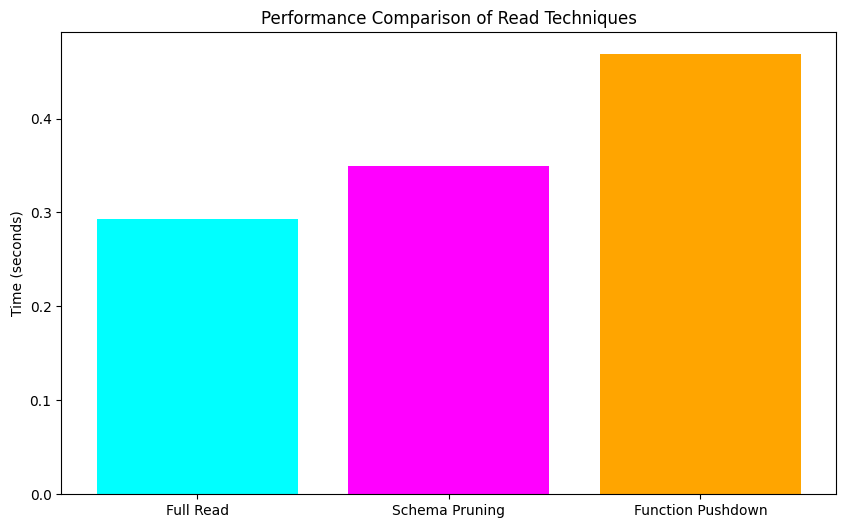

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import time

# Initialize Spark Session with optimized configurations
spark = SparkSession.builder \
    .appName("Efficient Data Processing") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "50") \
    .getOrCreate()

def measure_performance(operation, file_path, columns=None, filter_condition=None):
    start_time = time.time()

    # Load data with optional schema pruning
    if columns:
        df = spark.read.parquet(file_path).select(columns)
    else:
        df = spark.read.parquet(file_path)

    # Apply optional filter condition with function pushdown
    if filter_condition:
        df = df.filter(filter_condition)

    # Trigger action to measure read time
    df.count()

    end_time = time.time()
    return end_time - start_time

# Define file path and operations
file_path = '/content/partitioned_data/10001_49999'

# Performance without schema pruning or function pushdown
time_full = measure_performance("Full Read", file_path)

# Performance with schema pruning
columns = ["customer_id", "loan_amnt"]  # Corrected column names
time_pruned = measure_performance("Pruned Read", file_path, columns=columns)

# Performance with function pushdown
filter_condition = "loan_amnt > 1000"  # Corrected example condition
time_pushdown = measure_performance("Filtered Read", file_path, filter_condition=filter_condition)

# Visualize the performance comparison
times = [time_full, time_pruned, time_pushdown]
methods = ['Full Read', 'Schema Pruning', 'Function Pushdown']

# Change color palette here
colors = ['cyan', 'magenta', 'orange']  # New color palette

plt.figure(figsize=(10, 6))
plt.bar(methods, times, color=colors)
plt.ylabel('Time (seconds)')
plt.title('Performance Comparison of Read Techniques')
plt.show()

# Stop the Spark session
spark.stop()


In [ ]:
import time
import resource
from pyspark.sql import SparkSession

def get_cpu_times():
    usage = resource.getrusage(resource.RUSAGE_SELF)
    return usage.ru_utime, usage.ru_stime  # User time and System time

def measure_performance_with_resources(operation, file_path, columns=None, filter_condition=None):
    start_user, start_sys = get_cpu_times()
    start_time = time.time()

    # Load data with optional schema pruning
    df = spark.read.parquet(file_path)
    if columns:
        df = df.select(columns)
    if filter_condition:
        df = df.filter(filter_condition)

    # Trigger action to measure read time
    df.count()

    end_time = time.time()
    end_user, end_sys = get_cpu_times()

    # Calculate times
    user_time = end_user - start_user
    sys_time = end_sys - start_sys
    total_time = user_time + sys_time
    wall_time = end_time - start_time

    return user_time, sys_time, total_time, wall_time

# Initialize Spark Session with optimized configurations
spark = SparkSession.builder \
    .appName("Efficient Data Processing") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "50") \
    .getOrCreate()

# Define file path and operations
file_path = '/content/partitioned_data/10001_49999'

# Measure performance without schema pruning or function pushdown
print("\nMeasuring Full Read:")
full_times = measure_performance_with_resources("Full Read", file_path)
print(f"User CPU Time: {full_times[0]:.4f} seconds")
print(f"System CPU Time: {full_times[1]:.4f} seconds")
print(f"Total CPU Time: {full_times[2]:.4f} seconds")
print(f"Wall Time: {full_times[3]:.4f} seconds")

# Measure performance with schema pruning
print("\nMeasuring Pruned Read:")
pruned_times = measure_performance_with_resources("Pruned Read", file_path, columns=["customer_id", "loan_amnt"])
print(f"User CPU Time: {pruned_times[0]:.4f} seconds")
print(f"System CPU Time: {pruned_times[1]:.4f} seconds")
print(f"Total CPU Time: {pruned_times[2]:.4f} seconds")
print(f"Wall Time: {pruned_times[3]:.4f} seconds")

# Measure performance with function pushdown
print("\nMeasuring Filtered Read:")
filtered_times = measure_performance_with_resources("Filtered Read", file_path, filter_condition="loan_amnt > 1000")
print(f"User CPU Time: {filtered_times[0]:.4f} seconds")
print(f"System CPU Time: {filtered_times[1]:.4f} seconds")
print(f"Total CPU Time: {filtered_times[2]:.4f} seconds")
print(f"Wall Time: {filtered_times[3]:.4f} seconds")

# Stop the Spark session
spark.stop()



Measuring Full Read:
User CPU Time: 0.0038 seconds
System CPU Time: 0.0010 seconds
Total CPU Time: 0.0048 seconds
Wall Time: 0.2588 seconds

Measuring Pruned Read:
User CPU Time: 0.0103 seconds
System CPU Time: 0.0022 seconds
Total CPU Time: 0.0125 seconds
Wall Time: 0.4520 seconds

Measuring Filtered Read:
User CPU Time: 0.0060 seconds
System CPU Time: 0.0012 seconds
Total CPU Time: 0.0071 seconds
Wall Time: 0.2996 seconds
